# Sequencing - Execution time + Improvement Evaluation  

In [290]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import psycopg2
import pandas as pd

In [291]:
# Connecting to Redshift

# Redshift Connection 
# Create a global variable for the database connection
connection = None

# Connect to Amazon Redshift
def connect_to_redshift():
    try:
        conn = psycopg2.connect(
        host='dwh-redshift.sandbox.verses.build',
            port='5439',
            database='ds_dwh',
            user='dwh_operator',
            password='G$@4333sHK^RuuYA'
        )
        print("Connected to Redshift")
        return conn
    except psycopg2.Error as e:
        print("Error connecting to Redshift:", e)
        return None

# Execute SQL query 
def execute_query(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]
        cur.close()
        connection.commit()  # Explicitly commit the transaction
        return rows, column_names
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution

# A function to create Temp Table 
def cretae_temp_table(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        cur.close()
        connection.commit()  # Explicitly commit the transaction
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution
        
# Example SQL query
query = """SELECT * FROM raw_aspire_picks 
LIMIT 100
""" 

# Create DataFrame
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)

Connected to Redshift


In [292]:
# RefPickData
# read from raw_aspire_picks
query = """DROP TABLE IF EXISTS RefPickData;

CREATE TEMP TABLE RefPickData AS
SELECT 
facilityname as facility_name,
employeenumber as employee_number,
assignmentnumber as assignment_number,
assignmentstarttime as assignment_start_time,
assignmentendtime as assignment_end_time,
picktypedescription as pick_type,
fastpicked as fast_picked,
taskstartdate as task_start_time,
taskenddate as task_end_time,
itemnumber as sku,
quantitypicked as quantity_picked,
taskstatusdescription as task_status,
fromlocation as location,
SPLIT_PART(fromlocation, '-', 1) AS warehouse_id,
SPLIT_PART(fromlocation, '-', 2) AS asile,
SPLIT_PART(fromlocation, '-', 3) AS section,
SPLIT_PART(fromlocation, '-', 4) AS level,
SPLIT_PART(fromlocation, '-', 5) AS column_num,
name as brand,
CASE WHEN subdocumenttype = '' THEN 'other' ELSE subdocumenttype END as order_type,
'NRI' as client
FROM raw_aspire_picks
WHERE 
DATE_TRUNC('day', taskenddate) >= '2023-01-01'
AND 
DATE_TRUNC('day', taskenddate) <= '2023-07-01'
AND 
facilityname = 'LD'
AND 
asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
AND
section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
AND 
"""

# read from stg_picks
query = """DROP TABLE IF EXISTS RefPickData;
CREATE TEMP TABLE RefPickData AS
SELECT 
facility_name, 
external_employee_id as employee_number, 
external_assignment_id as assignment_number, 
assignment_start_time,
assignment_end_time,
pick_type,
fast_picked,
task_start_time,
task_end_time,
sku,
quantity_picked,
task_status,
location,
SPLIT_PART(location, '-', 1) AS warehouse_id,
SPLIT_PART(location, '-', 2) AS asile,
SPLIT_PART(location, '-', 3) AS section,
SPLIT_PART(location, '-', 4) AS level,
SPLIT_PART(location, '-', 5) AS column_num,
brand,
CASE WHEN order_type = '' THEN 'other' ELSE order_type END as order_type,
client
FROM stg_picks
WHERE 
DATE_TRUNC('day', task_end_time) >= '2022-01-01'
AND 
DATE_TRUNC('day', task_end_time) <= '2024-01-01'
AND 
facility_name = 'LD'
--AND 
--asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
--AND
--section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
"""

cretae_temp_table(query)

query = """SELECT * FROM RefPickData"""

# Execute the query
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
total_num_records, _ = df.shape
total_num_records

2680211

In [293]:
# Find Duplicated Records 
query = """WITH duplicates AS (
    SELECT  facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type,
           ROW_NUMBER() OVER (PARTITION BY facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type) AS row_num
    FROM RefPickData)
    
    SELECT * FROM duplicates
    WHERE row_num > 1
    order by assignment_start_time
    """

results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
if len(df)>0:
    print("there is duplciated records")
df.head()

,facility_name,employee_number,assignment_number,assignment_start_time,assignment_end_time,pick_type,fast_picked,task_start_time,task_end_time,sku,quantity_picked,task_status,location,asile,section,level,column_num,brand,order_type,row_num


In [301]:
# get the list of all historical assignments 
query = """SELECT 
employee_number, 
assignment_start_time, 
assignment_end_time, 
assignment_number, 
EXTRACT(epoch FROM (assignment_end_time - assignment_start_time)) as assignment_time, 
count(*) as assignment_length,
min(task_start_time) as task_start_time, 
max(task_end_time) as task_end_time
FROM RefPickData
GROUP BY employee_number, assignment_start_time, assignment_end_time, assignment_number
--HAVING assignment_number = '20203779'
ORDER BY task_start_time DESC"""
results, columns = execute_query(query)
historical_assginment = pd.DataFrame(results, columns=columns)

historical_assginment.columns = ['hist_employee_number', 'hist_assignment_start_time', 'hist_assignment_end_time',
       'hist_assignment_number', 'hist_assignment_time', 'hist_assignment_length',
       'hist_task_start_time', 'hist_task_end_time']
historical_assginment.head()

,hist_employee_number,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_number,hist_assignment_time,hist_assignment_length,hist_task_start_time,hist_task_end_time
0,07899,2023-09-18 13:55:34.927000+00:00,2023-09-18 13:58:01.317000+00:00,20779303,146.0,1,2023-09-18 13:56:31.800000+00:00,2023-09-18 13:58:01.273000+00:00
1,06038,2023-09-18 13:55:19.393000+00:00,2023-09-18 13:59:04.063000+00:00,20779295,224.0,7,2023-09-18 13:56:22.537000+00:00,2023-09-18 13:59:04.040000+00:00
2,02044,2023-09-18 13:54:02.763000+00:00,2023-09-18 13:58:29.177000+00:00,20779270,266.0,9,2023-09-18 13:54:41.353000+00:00,2023-09-18 13:58:29.147000+00:00
3,07899,2023-09-18 13:49:25.473000+00:00,2023-09-18 13:55:33.400000+00:00,20779178,367.0,10,2023-09-18 13:50:30.207000+00:00,2023-09-18 13:55:21.600000+00:00
4,05149,2023-09-18 13:50:04.547000+00:00,2023-09-18 13:59:38.940000+00:00,20779193,574.0,10,2023-09-18 13:50:21.083000+00:00,2023-09-18 13:59:06.893000+00:00


In [302]:
# calculate assignment length frequency based on historical assignment 
historical_length_freq = historical_assginment['hist_assignment_length'].value_counts().reset_index()
historical_length_freq.columns = ['hist_assignment_length', 'hist_count']
total_count = historical_length_freq['hist_count'].sum()
historical_length_freq['hist_freq'] = (historical_length_freq['hist_count'] / total_count) * 100

historical_length_freq

,hist_assignment_length,hist_count,hist_freq
0,2,37725,16.624216
1,1,35498,15.642847
2,3,17794,7.841254
3,4,13698,6.036276
4,5,10952,4.826200
...,...,...,...
199,232,1,0.000441
200,194,1,0.000441
201,261,1,0.000441
202,223,1,0.000441


# The CSV file from executing Alex code 

In [361]:
# Load data
# optimized_analysis = pd.read_csv('analysis_data\LD_testrun_results_2022-05-10.csv')  # old data based on alex analysis
optimized_analysis = pd.read_csv('analysis_data\LD_testrun_results.csv')  # new analysis based on the data from 2022-08-01 to 2023-08-01
optimized_analysis.columns = ['Unnamed: 0', 'opt_assignment_number', 'opt_assignment_length',
       'UnoptimizedSequence', 'OptimizedSequence', 'UnoptimizedDistance',
       'OptimizedDistance', 'DistanceSavings', 'SavingsPercent',
       'ExecutionTime', 'NumParallelRuns', 'Algorithm']
optimized_analysis.head()

,Unnamed: 0,opt_assignment_number,opt_assignment_length,UnoptimizedSequence,OptimizedSequence,UnoptimizedDistance,OptimizedDistance,DistanceSavings,SavingsPercent,ExecutionTime,NumParallelRuns,Algorithm
0,0,14734108,3,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,87.368785,87.368785,0.000000,0.000000,9.684491,4,annealing
1,1,14734310,6,Delivery zone|LD-14-02-04-B|LD-14-02-04-C|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,80.315314,61.978628,18.336686,0.228309,9.869215,4,annealing
2,2,14734353,3,Delivery zone|LD-79-03-03-F|LD-DIS-03-02-04|LD...,Delivery zone|LD-DIS-03-02-04|LD-79-07-03-H|LD...,170.008211,104.226116,65.782095,0.386935,10.562571,4,annealing
3,3,14734540,3,Delivery zone|LD-75-15-03-A|LD-80-01-03-B|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,131.260521,131.260521,0.000000,0.000000,10.481968,4,annealing
4,4,14735165,9,Delivery zone|LD-77-04-04-B|LD-75-03-03-E|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,286.363445,159.358508,127.004936,0.443510,10.347075,4,annealing


In [386]:
# join optimized_analysis with assignment data 
optimized_analysis['opt_assignment_number'] = optimized_analysis['opt_assignment_number'].astype(str)
historical_assginment['hist_assignment_number'] = historical_assginment['hist_assignment_number'].astype(str)

historical_versus_optimzied_df = pd.merge(optimized_analysis, historical_assginment, 
                                          left_on='opt_assignment_number', 
                                          right_on='hist_assignment_number', 
                                          how = 'left')

historical_versus_optimzied_df = historical_versus_optimzied_df[['opt_assignment_number', 
                                                                 'opt_assignment_length', 
                                                                 'hist_assignment_number', 
                                                                 'hist_assignment_length',
                                                                 'UnoptimizedSequence', 'OptimizedSequence', 'UnoptimizedDistance', 'OptimizedDistance', 
                                                                 'DistanceSavings', 'SavingsPercent',
                                                                 'ExecutionTime', 'NumParallelRuns', 'Algorithm', 
                                                                 'hist_employee_number', 
                                                                 'hist_assignment_start_time', 'hist_assignment_end_time', 'hist_assignment_time', 
                                                                 'hist_task_start_time', 'hist_task_end_time']]

historical_versus_optimzied_df['opt_assignment_number'] = historical_versus_optimzied_df['opt_assignment_number'].astype(str)
historical_versus_optimzied_df['opt_assignment_length'] = historical_versus_optimzied_df['opt_assignment_length'].astype(int)
historical_versus_optimzied_df['hist_assignment_number'] = historical_versus_optimzied_df['hist_assignment_number'].astype(str)
historical_versus_optimzied_df['UnoptimizedDistance'] = historical_versus_optimzied_df['UnoptimizedDistance'].astype(float)
historical_versus_optimzied_df['OptimizedDistance'] = historical_versus_optimzied_df['OptimizedDistance'].astype(float)
historical_versus_optimzied_df['DistanceSavings'] = historical_versus_optimzied_df['DistanceSavings'].astype(float)
historical_versus_optimzied_df['SavingsPercent'] = historical_versus_optimzied_df['SavingsPercent'].astype(float)
historical_versus_optimzied_df['ExecutionTime'] = historical_versus_optimzied_df['ExecutionTime'].astype(float)
historical_versus_optimzied_df['NumParallelRuns'] = historical_versus_optimzied_df['NumParallelRuns'].astype(str)
historical_versus_optimzied_df['hist_employee_number'] = historical_versus_optimzied_df['hist_employee_number'].astype(str)
historical_versus_optimzied_df['hist_assignment_start_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_assignment_start_time'])
historical_versus_optimzied_df['hist_assignment_end_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_assignment_end_time'])
historical_versus_optimzied_df['hist_assignment_time'] = historical_versus_optimzied_df['hist_assignment_time'].astype('float')
historical_versus_optimzied_df['hist_task_start_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_task_start_time'])
historical_versus_optimzied_df['hist_task_end_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_task_end_time'])

historical_versus_optimzied_df[historical_versus_optimzied_df.isna().any(axis=1)]

,opt_assignment_number,opt_assignment_length,hist_assignment_number,hist_assignment_length,UnoptimizedSequence,OptimizedSequence,UnoptimizedDistance,OptimizedDistance,DistanceSavings,SavingsPercent,ExecutionTime,NumParallelRuns,Algorithm,hist_employee_number,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_time,hist_task_start_time,hist_task_end_time


In [460]:
# filter the data you need 
filter_historical_versus_optimzied_df = historical_versus_optimzied_df[(historical_versus_optimzied_df['opt_assignment_length']<=10)]

#filter_historical_versus_optimzied_df = historical_versus_optimzied_df

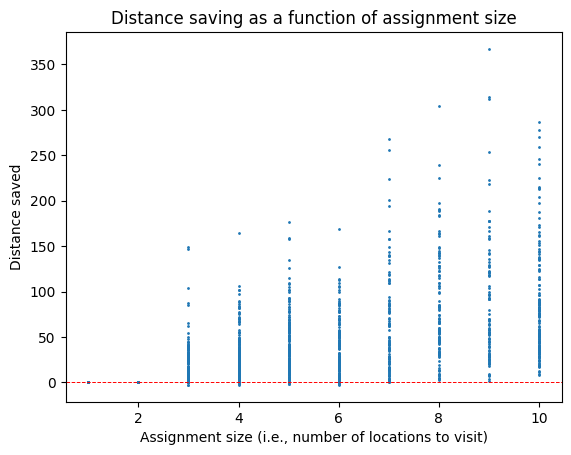

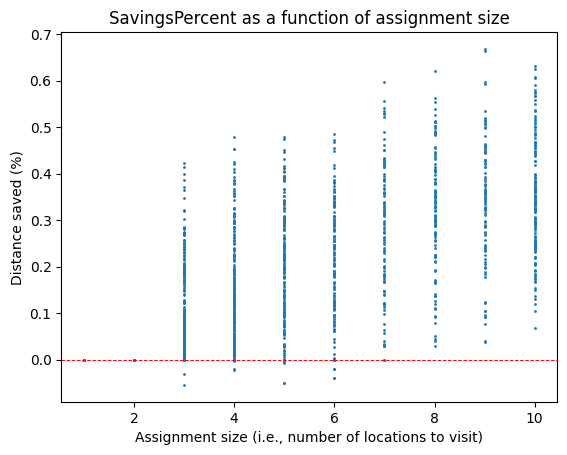

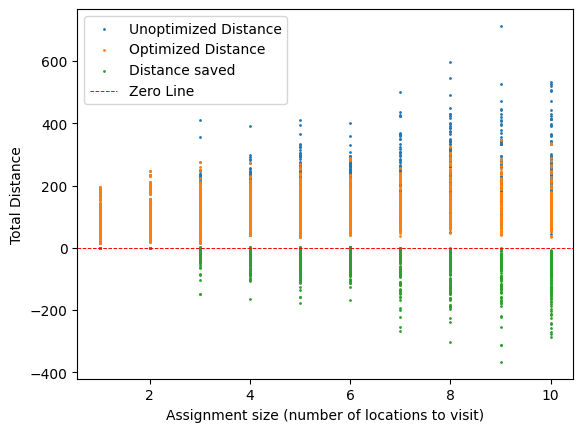

In [461]:
# plot distance saved as a function of assignment size *individual assignments*

data = filter_historical_versus_optimzied_df

plt.scatter(data['opt_assignment_length'], data['DistanceSavings'], s=1)
plt.ylabel('Distance saved')
plt.xlabel('Assignment size (i.e., number of locations to visit)')
plt.title('Distance saving as a function of assignment size')
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.show()

plt.scatter(data['opt_assignment_length'], data['SavingsPercent'], s=1)
plt.ylabel('Distance saved (%)')
plt.xlabel('Assignment size (i.e., number of locations to visit)')
plt.title('SavingsPercent as a function of assignment size')
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.show()

x = data["opt_assignment_length"]
y1 = data["UnoptimizedDistance"]
y2 = data["OptimizedDistance"]
y3 = data["OptimizedDistance"] - data["UnoptimizedDistance"]

plt.scatter(x, y1, label="Unoptimized Distance", s=1)
plt.scatter(x, y2, label="Optimized Distance", s=1)
plt.scatter(x, y3, label="Distance saved", s=1)
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.xlabel("Assignment size (number of locations to visit)")
plt.ylabel("Total Distance")
plt.legend()
plt.savefig(f'plots/optimized versus unoptimized.png')
plt.show()

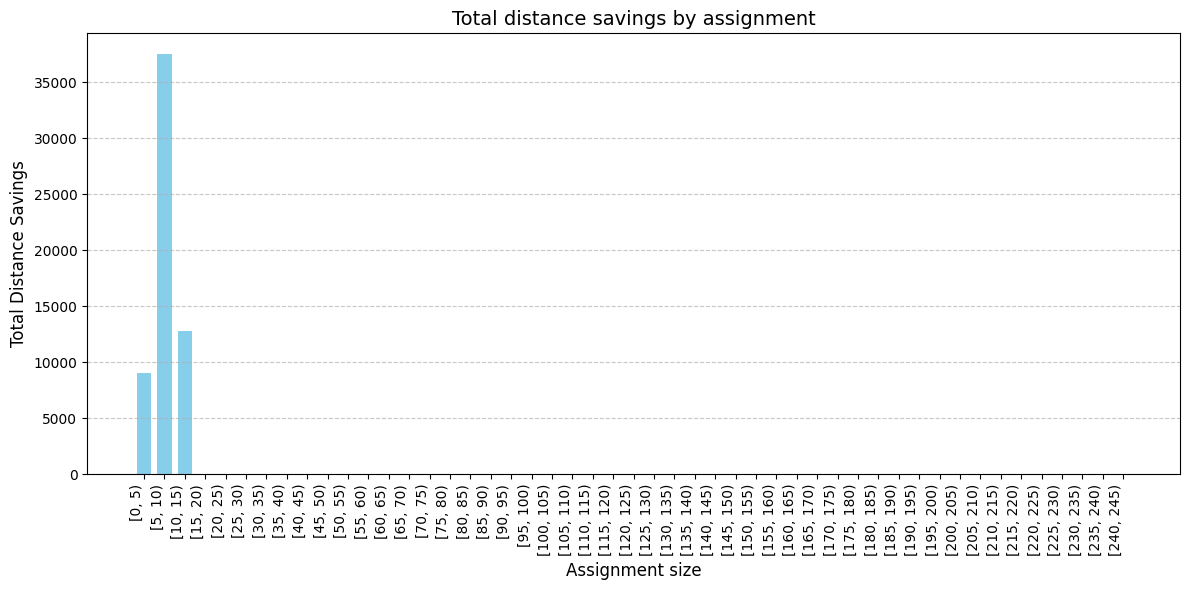

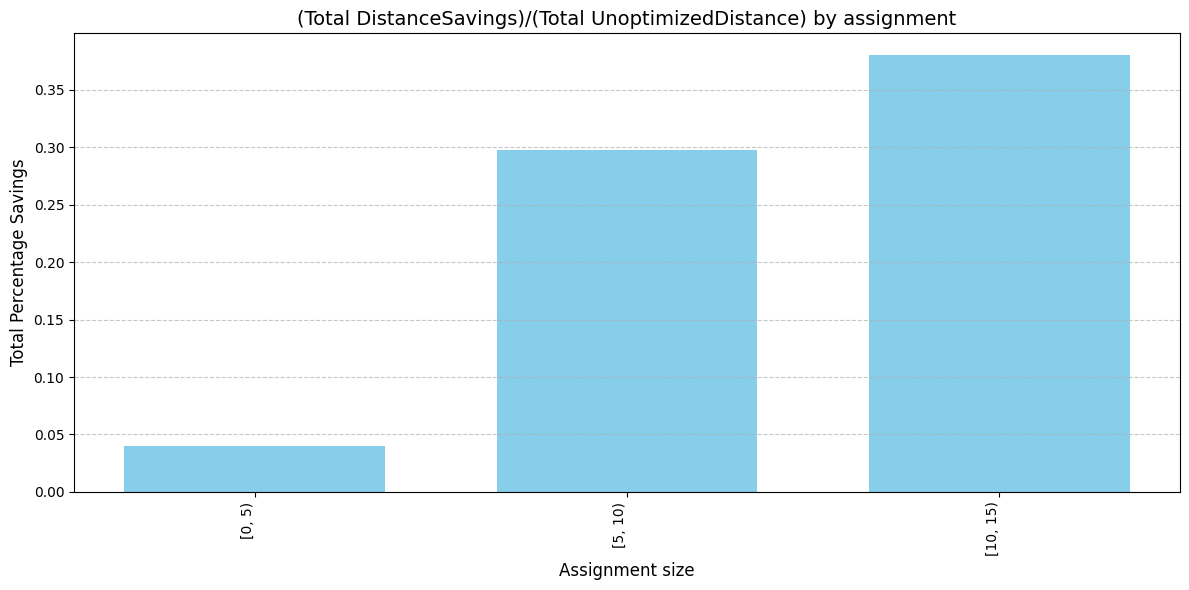

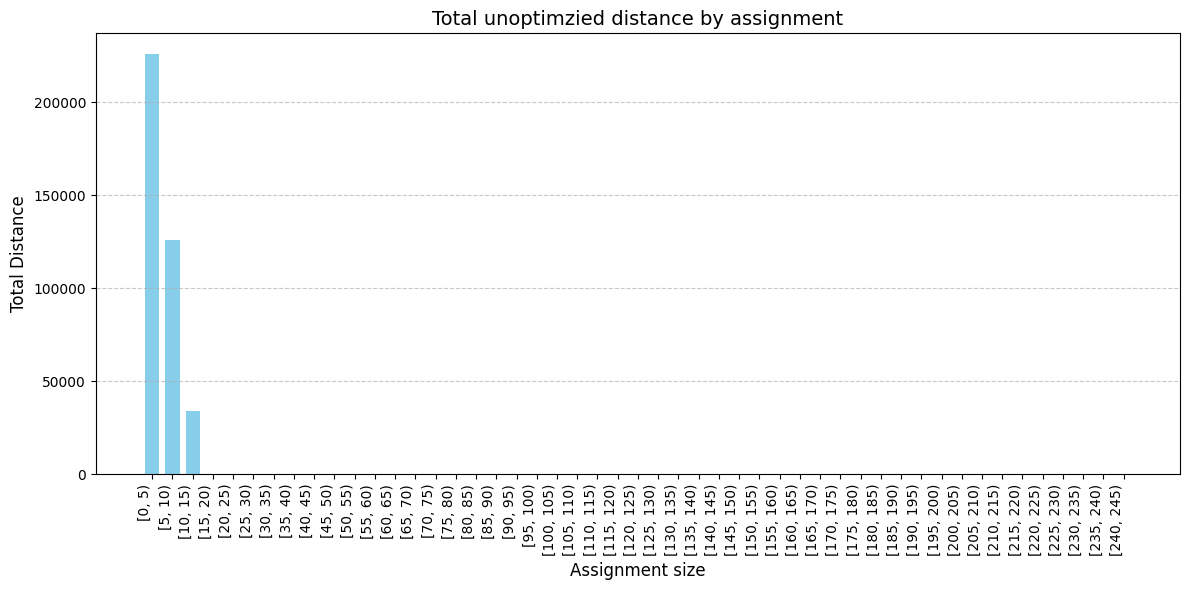

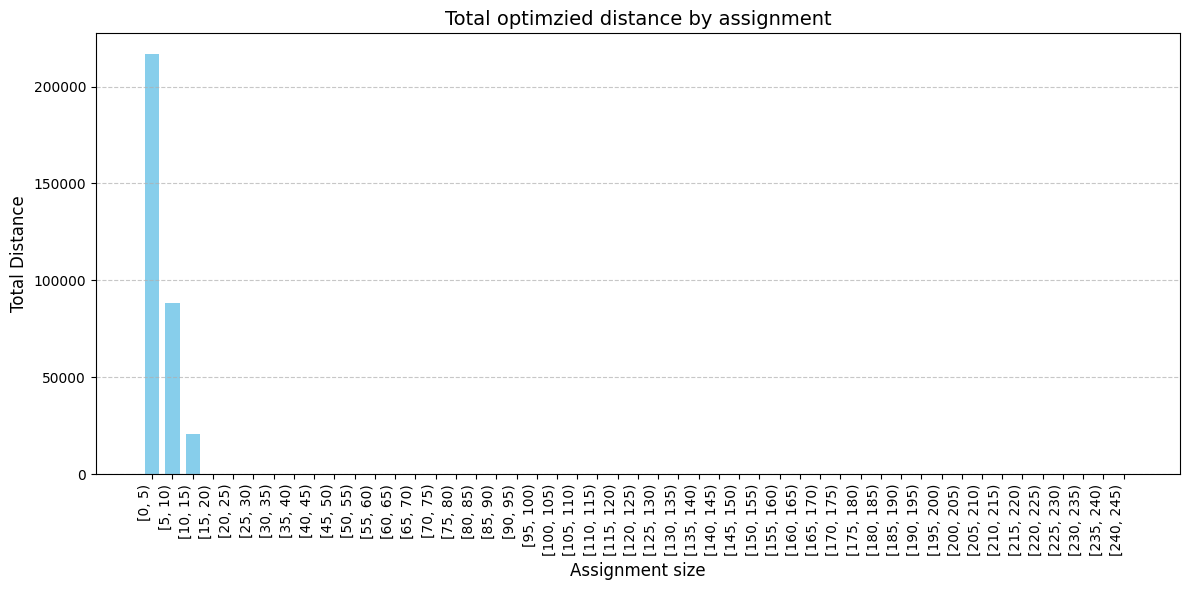

In [462]:
# saving for different buckets based on assignment size 

bin_edges = range(0, 250, 5)  # Creates bins [0, 5), [5, 10), [10, 15), ..., [45, 50)

bins = pd.cut(filter_historical_versus_optimzied_df['opt_assignment_length'], bins=bin_edges, right=False)

result = filter_historical_versus_optimzied_df.groupby(bins)[['OptimizedDistance', 'UnoptimizedDistance', 'DistanceSavings']].sum().reset_index()
result['opt_assignment_length'] = result['opt_assignment_length'].astype('str')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['DistanceSavings'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance Savings', fontsize=12)
plt.title('Total distance savings by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['DistanceSavings']/result['UnoptimizedDistance'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Percentage Savings', fontsize=12)
plt.title('(Total DistanceSavings)/(Total UnoptimizedDistance) by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['UnoptimizedDistance'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance', fontsize=12)
plt.title('Total unoptimzied distance by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['OptimizedDistance'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance', fontsize=12)
plt.title('Total optimzied distance by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 

In [463]:
# group by assignment and add hist_freq and opt_freq

# Calculate the frequency count and percentage for 'opt_assignment_length
opt_length_freq = filter_historical_versus_optimzied_df['opt_assignment_length'].value_counts().reset_index()
opt_length_freq.columns = ['opt_assignment_length', 'opt_count']
total_count = opt_length_freq['opt_count'].sum()
opt_length_freq['opt_freq'] = (opt_length_freq['opt_count'] / total_count) * 100

# create a freq_table 
freq_table = pd.merge(historical_length_freq, 
                      opt_length_freq, 
                      left_on='hist_assignment_length', 
                      right_on='opt_assignment_length', 
                      how='right')

cols = ['opt_assignment_number', 'opt_assignment_length', 'UnoptimizedDistance', 'OptimizedDistance', 'DistanceSavings', 'SavingsPercent',
         'ExecutionTime', 'NumParallelRuns']
hist_optimzied_group_by = filter_historical_versus_optimzied_df[cols]
hist_optimzied_group_by = hist_optimzied_group_by.groupby('opt_assignment_length').sum()[['UnoptimizedDistance', 
                                                                                                          'OptimizedDistance',
                                                                                                          'DistanceSavings']].reset_index()
merge_freq_hist_optimized = pd.merge(hist_optimzied_group_by, freq_table, on='opt_assignment_length', how='left')
merge_freq_hist_optimized.head()

C:\Users\Hasan\AppData\Local\Temp\ipykernel_24836\1390189357.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hist_optimzied_group_by = hist_optimzied_group_by.groupby('opt_assignment_length').sum()[['UnoptimizedDistance',


,opt_assignment_length,UnoptimizedDistance,OptimizedDistance,DistanceSavings,hist_assignment_length,hist_count,hist_freq,opt_count,opt_freq
0,1,54615.419577,54615.419577,0.000000,1,35498,15.642847,951,27.766423
1,2,83075.789700,83075.789700,0.000000,2,37725,16.624216,930,27.153285
2,3,51390.103026,47851.786695,3538.316331,3,17794,7.841254,464,13.547445
3,4,36571.691493,31082.089757,5489.601737,4,13698,6.036276,273,7.970803
4,5,31128.575634,24151.796340,6976.779294,5,10952,4.826200,202,5.897810


,opt_assignment_length,UnoptimizedDistance,OptimizedDistance,DistanceSavings,hist_assignment_length,hist_count,hist_freq,opt_count,opt_freq,total saving,weighted saving
0,1,54615.419577,54615.419577,0.000000,1,35498,15.642847,951,27.766423,0.000000,15.400764
1,2,83075.789700,83075.789700,0.000000,2,37725,16.624216,930,27.153285,0.000000,15.400764
2,3,51390.103026,47851.786695,3538.316331,3,17794,7.841254,464,13.547445,3538.316331,15.400764
3,4,36571.691493,31082.089757,5489.601737,4,13698,6.036276,273,7.970803,5489.601737,15.400764
4,5,31128.575634,24151.796340,6976.779294,5,10952,4.826200,202,5.897810,6976.779294,15.400764


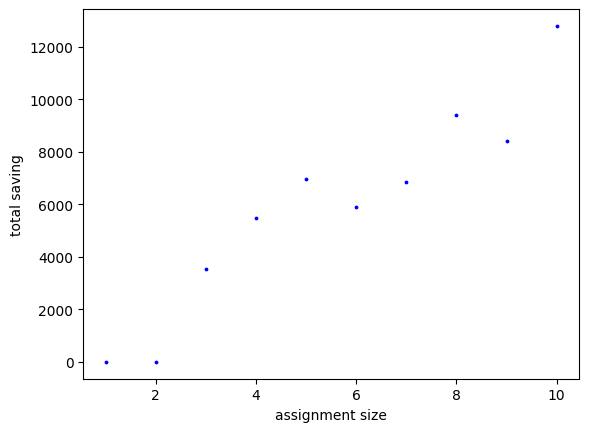

In [464]:
# calculate the total improvment 
merge_freq_hist_optimized['total saving'] = (merge_freq_hist_optimized['UnoptimizedDistance'] - merge_freq_hist_optimized['OptimizedDistance'])
merge_freq_hist_optimized['weighted saving'] = (merge_freq_hist_optimized['UnoptimizedDistance'].sum() - 
                                merge_freq_hist_optimized['OptimizedDistance'].sum())/merge_freq_hist_optimized['UnoptimizedDistance'].sum()*100

plt.scatter(merge_freq_hist_optimized['opt_assignment_length'], merge_freq_hist_optimized['total saving'], s=3, color='blue')
plt.ylabel('total saving')
plt.xlabel('assignment size')

merge_freq_hist_optimized.head()

# Estimate computational time

In [465]:
historical_versus_optimzied_df["ExecutionTime"].mean()
historical_versus_optimzied_df["ExecutionTime"].max()
historical_versus_optimzied_df["ExecutionTime"].std()
df = historical_versus_optimzied_df[(historical_versus_optimzied_df["ExecutionTime"] < 200) 
& ((historical_versus_optimzied_df["opt_assignment_length"] > 3) 
   | (historical_versus_optimzied_df["opt_assignment_length"] < 100))]

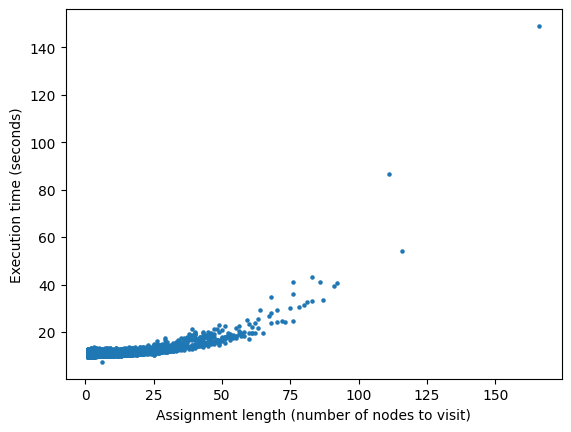

In [466]:
plt.scatter(df1["opt_assignment_length"], df1["ExecutionTime"], s=5)
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Execution time (seconds)")
plt.savefig('plots/computational time.png')